In [ ]:
#https://docs.google.com/spreadsheets/d/e/2PACX-1vTIVDiundedynwroWdY5At3Ix8-INZXvHBBKS75uq9ryL30Qa36_GCv6o214pbLcAlDyCFfOdf-aQGs/pub?gid=976213869&single=true&output=csv

In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
!pip install pmdarima --quiet
import pmdarima as pm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.6 MB/s eta 0:00:00


In [ ]:
data = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vTIVDiundedynwroWdY5At3Ix8-INZXvHBBKS75uq9ryL30Qa36_GCv6o214pbLcAlDyCFfOdf-aQGs/pub?gid=976213869&single=true&output=csv")

#string to date format
df=data[:30]
df['date'] = pd.to_datetime(df['date'],infer_datetime_format=True)
df = df.set_index(['date'])
df.head(5)

<ipython-input-3-93eff0ad349d>:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'],infer_datetime_format=True)
<ipython-input-3-93eff0ad349d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'],infer_datetime_format=True)


,kwh
date,
2023-08-18,30.23
2023-08-19,34.70
2023-08-20,41.48
2023-08-21,63.75
2023-08-22,87.49


In [ ]:
dftest=data.tail(7)
# dftest['date'] = pd.to_datetime(dftest['date'])
dftest = dftest.set_index(['date'])
dftest.head(7)

,kwh
date,
2023-09-17,688.51
2023-09-18,698.09
2023-09-19,721.52
2023-09-20,746.76
2023-09-21,773.61
2023-09-22,820.06
2023-09-23,830.20


In [ ]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, 2023-09-17 to 2023-09-23
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kwh     7 non-null      float64
dtypes: float64(1)
memory usage: 112.0+ bytes


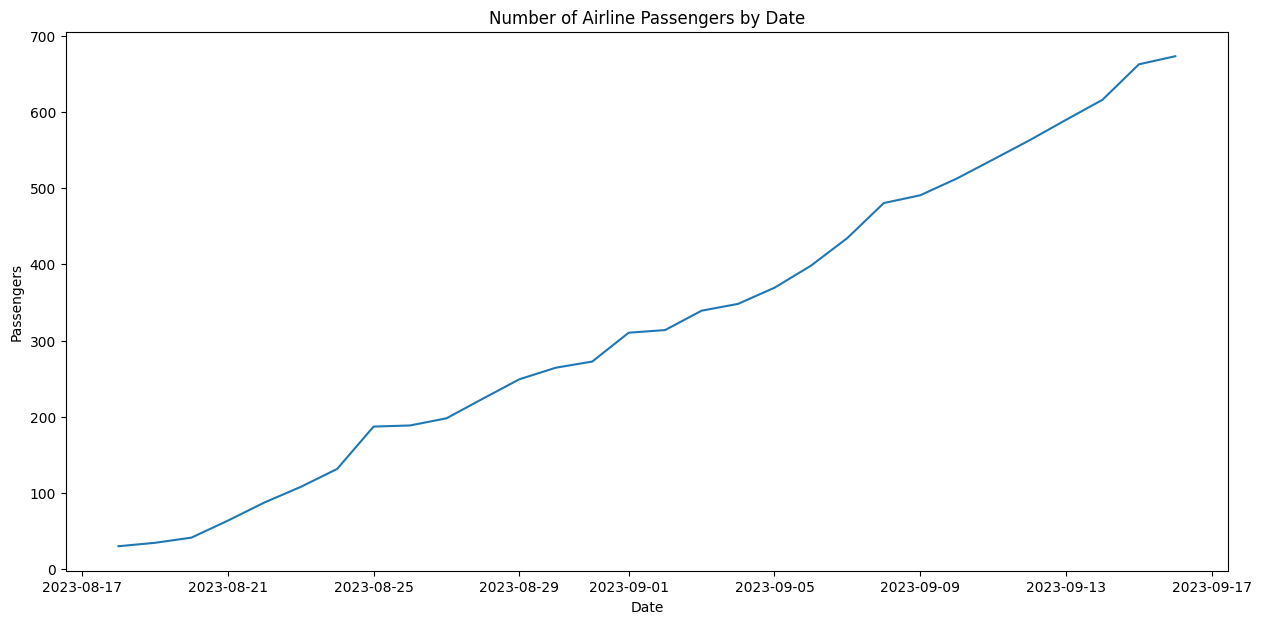

In [ ]:
plt.figure(figsize=(15,7))
plt.title("Number of Airline Passengers by Date")
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.plot(df)
plt.show()

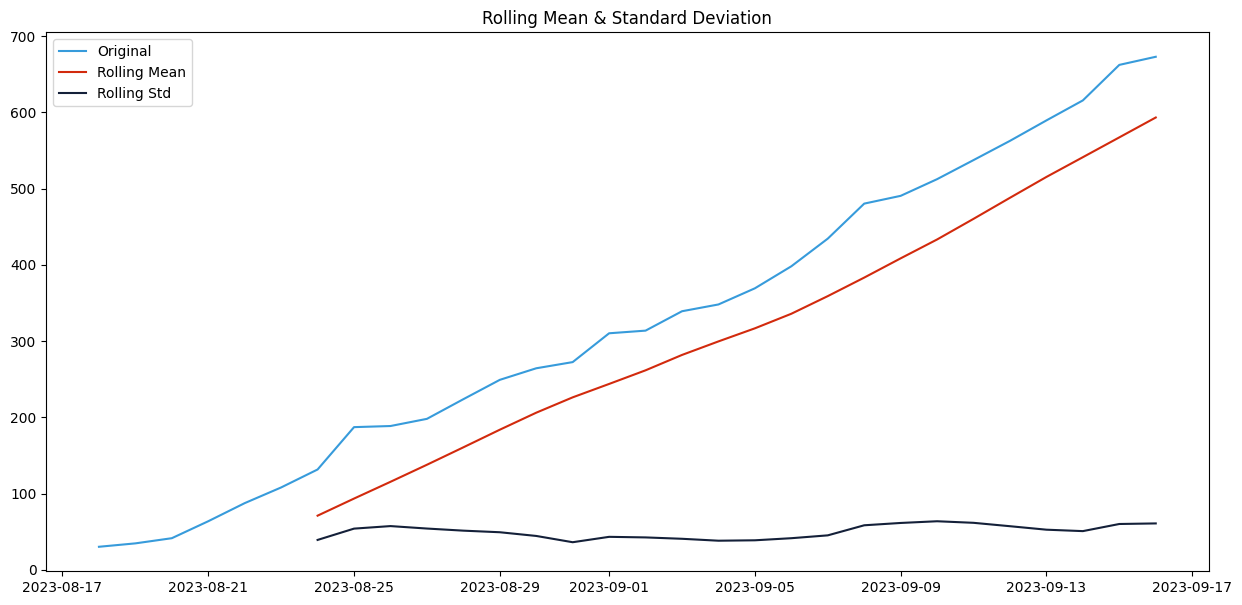

In [ ]:
#Determine rolling statistics
df["rolling_avg"] = df["kwh"].rolling(window=7).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["kwh"].rolling(window=7).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["kwh"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest_ad = adfuller(df['kwh'], autolag='AIC')

dfoutput = pd.Series(dftest_ad[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest_ad[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  1.678618
p-value                         0.998075
#Lags Used                      8.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


In [ ]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(df['kwh'],
                      start_p=1,
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

In [ ]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
def forecast(ARIMA_model, periods=7):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=periods, freq='D')
    true_val=dftest['kwh'].values
    true_Series=pd.Series(true_val,index=index_of_fc)
    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["kwh"], color='#1f76b4')
    plt.plot(true_Series, color='#ff76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Airline Passengers")
    plt.show()

forecast(ARIMA_model)

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df["kwh"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         m=7, #12 is the frequncy of the cycle
                         start_P=0,
                         seasonal=True, #set to seasonal
                         d=None,
                         D=0, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

In [ ]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
forecast(SARIMA_model)

In [ ]:
#adding exogenous variable
df['day_index'] = df.index.day

# SARIMAX Model
SARIMAX_model = pm.auto_arima(df[['kwh']], exogenous=df[['day_index']],
                           start_p=0, start_q=0,
                           test='adf',
                           max_p=2, max_q=2, m=7,
                           start_P=0, seasonal=True,
                           d=None, D=1,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

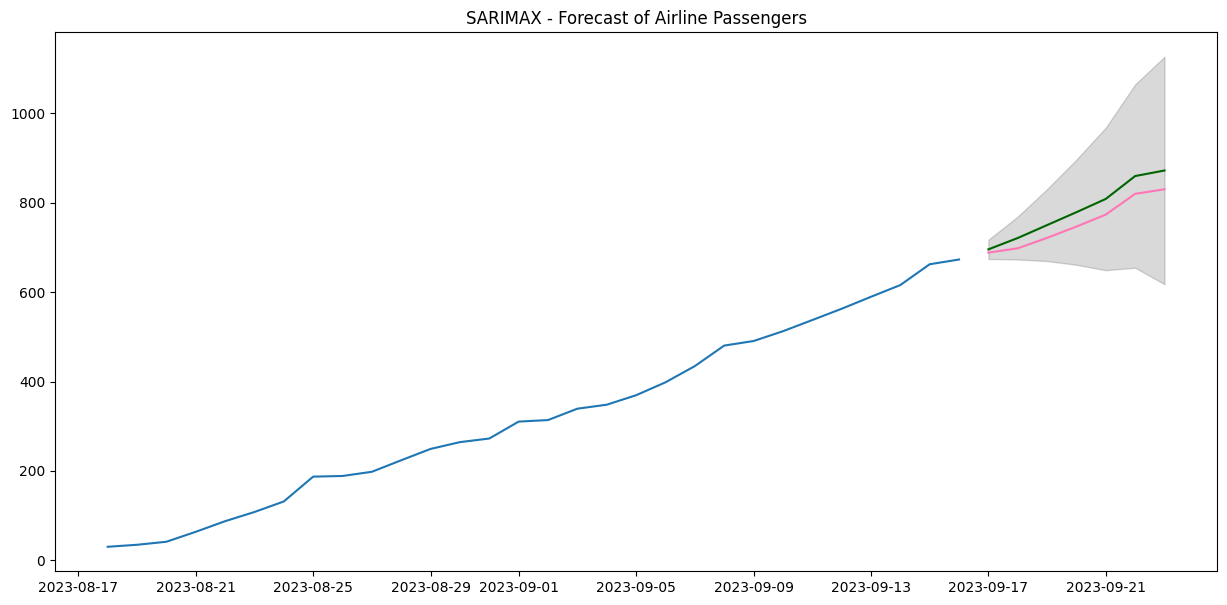

In [ ]:
def sarimax_forecast(SARIMAX_model, periods=30):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"day_index":pd.date_range(df.index[-1], periods = n_periods, freq='D').day},
                    index =pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=periods, freq='D'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods,
                                            return_conf_int=True,
                                            exogenous=forecast_df[['day_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=periods, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    true_val=dftest['kwh'].values
    true_Series=pd.Series(true_val,index=index_of_fc)
    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["kwh"], color='#1f76b4')
    plt.plot(true_Series, color='#ff76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline Passengers")
    plt.show()

sarimax_forecast(SARIMAX_model, periods=7)